In [1]:
import mplfinance as mpf
import pandas as pd
import ta
import optuna
import time
import numpy as np
from multiprocessing import Pool
from itertools import combinations, chain
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt

In [2]:
from utils_try import plot_candle_chart, file_features, buy_signals_1d, buy_signals_1h, buy_signals_1m, buy_signals_5m
from utils_try import sell_signals_1d, sell_signals_1h, sell_signals_1m, sell_signals_5m, plot_buy_sell_signals, data_fun
from utils_try import backtest, plot_operations_history, port_value_plot, plot_cash, cash_portvalue_plot, pasive_portvalue_plot

# Machin Learning

Nuestro proyecto de análisis de machine learning se centra en la exploración y modelado de conjuntos de validación proporcionados durante las primeras etapas del curso. En particular, nos sumergimos en la información financiera de la empresa AAPL (Apple Inc.), examinando meticulosamente sus datos de precios de cierre, máximos, mínimos, y otros indicadores relevantes.

In [3]:
data_1d = data_fun("aapl_1d_test.csv")
data_1h = data_fun("aapl_1h_test.csv")
data_1m = data_fun("aapl_1m_test.csv")
data_5m = data_fun("aapl_5m_test.csv")
data_1d.head()

,Date,Open,High,Low,Close,Adjusted_close,Volume
0,2021-02-17,131.25,132.22,129.47,130.84,128.7615,97918500
1,2021-02-18,129.20,130.00,127.41,129.71,127.6494,96856700
2,2021-02-19,130.24,130.71,128.80,129.87,127.8069,87668800
3,2021-02-22,128.01,129.72,125.60,126.00,123.9984,103916400
4,2021-02-23,123.76,126.71,118.39,125.86,123.8606,158273000


    Fecha: Indica la fecha en que se registraron los datos de precios de las acciones de Apple. Es esencial para seguir la evolución del precio a lo largo del tiempo y detectar patrones y tendencias.

    Apertura: Es el primer precio al que se negociaron las acciones de Apple en el día. Proporciona una indicación inicial de la dirección en que el precio puede moverse durante la jornada.

    Alto: Es el precio más alto alcanzado durante el día de negociación para las acciones de Apple. Indica el máximo alcanzado y la fuerza alcista del mercado.

    Bajo: Es el precio más bajo alcanzado durante el día de negociación. Indica el mínimo y la presión de venta en el mercado.

    Cierre: Es el último precio al que se negociaron las acciones en el día. Es uno de los más importantes, reflejando el valor final al que los inversores están dispuestos a comprar o vender las acciones.

    Cierre Ajustado: Considera eventos corporativos que afecten el precio de las acciones, como divisiones de acciones o dividendos. Ofrece una medida más precisa del rendimiento del precio de las acciones.

    Volumen: Indica la cantidad total de acciones de Apple negociadas durante el día. Puede señalar la fuerza detrás de los movimientos de precios: un alto volumen sugiere mayor interés y actividad, mientras que un bajo volumen puede indicar menor participación y volatilidad.

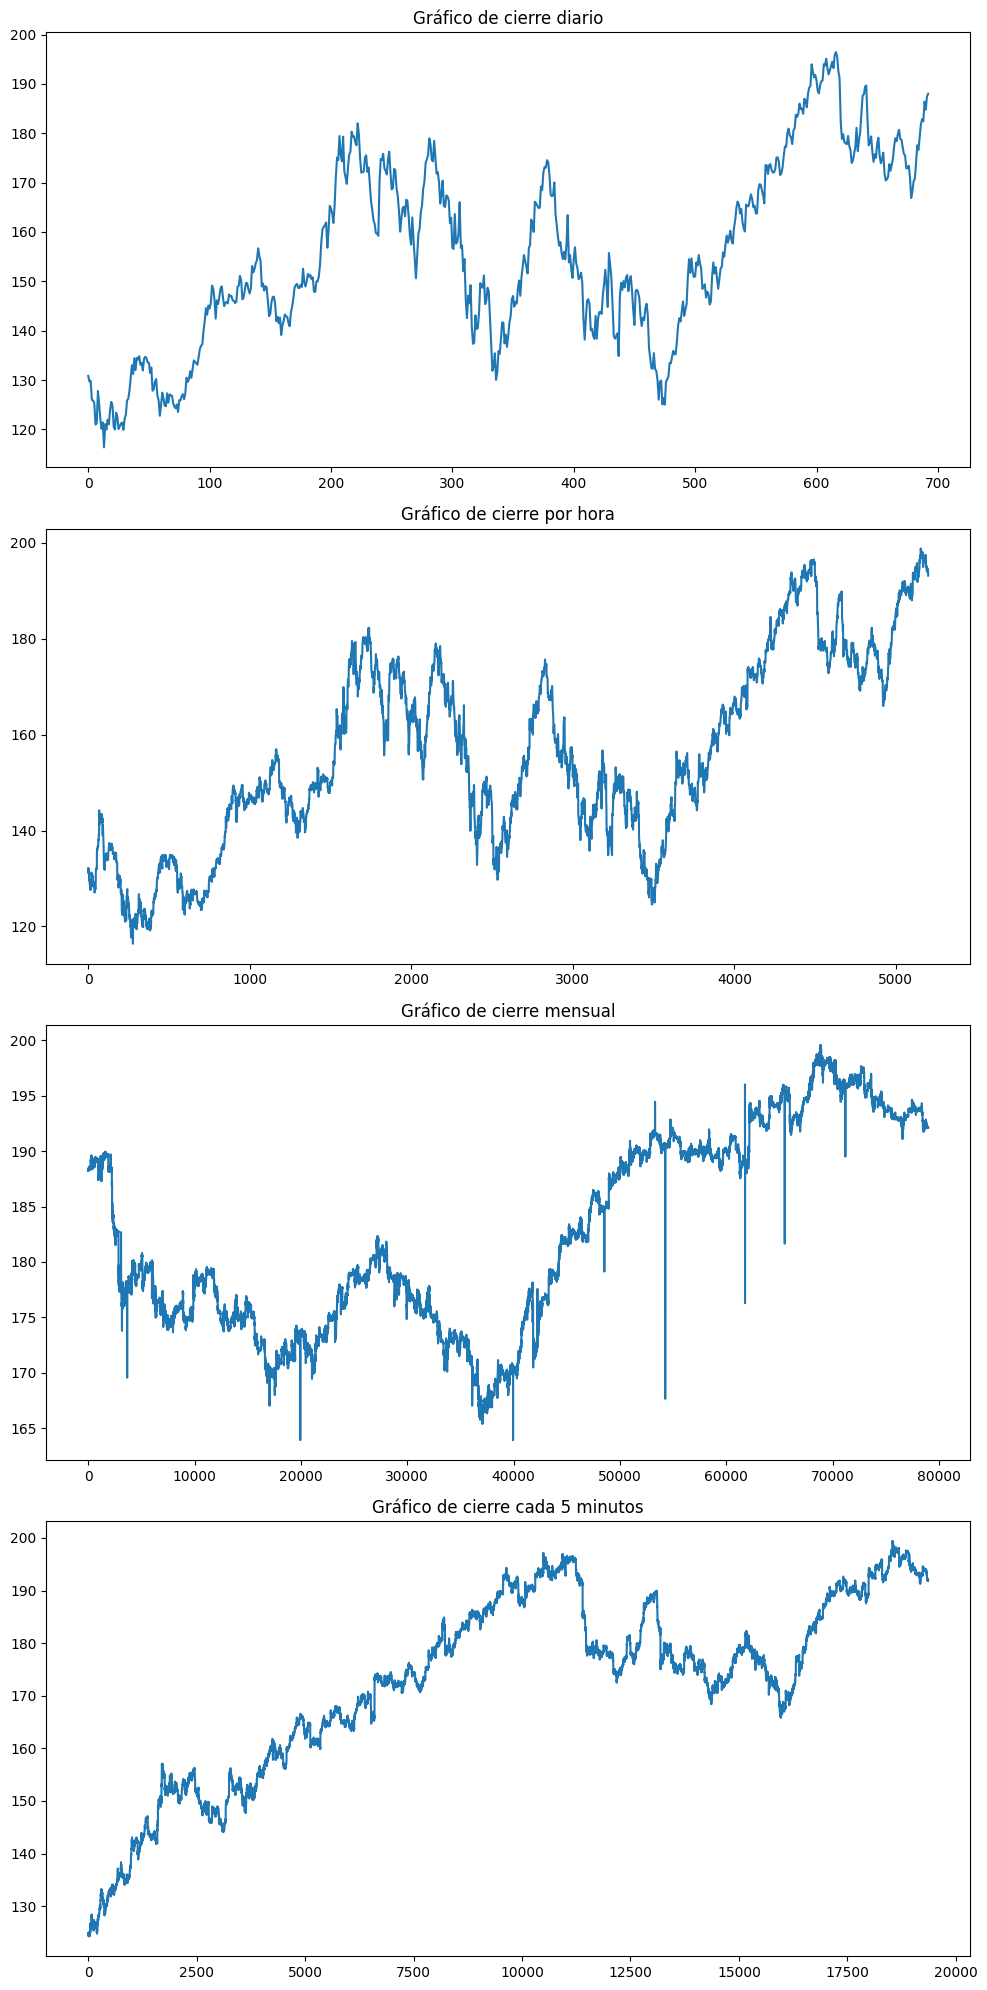

In [4]:
fig, axs = plt.subplots(4, figsize=(10, 20))
data_1d['Close'].plot(ax=axs[0])
axs[0].set_title('Gráfico de cierre diario')
data_1h['Close'].plot(ax=axs[1])
axs[1].set_title('Gráfico de cierre por hora')
data_1m['Close'].plot(ax=axs[2])
axs[2].set_title('Gráfico de cierre mensual')
data_5m['Close'].plot(ax=axs[3])
axs[3].set_title('Gráfico de cierre cada 5 minutos')
plt.tight_layout()
plt.show()

Las acciones de Apple (AAPL) han experimentado un crecimiento significativo en las últimas décadas. Desde su salida a bolsa en 1980, el precio de las acciones de Apple ha tenido varias tendencias alcistas y correcciones, pero en general ha mostrado una tendencia ascendente a largo plazo.

La variación del precio de las acciones de Apple a menudo está relacionada con el rendimiento de sus productos y la innovación tecnológica. El lanzamiento de nuevos productos exitosos, como el iPhone, iPad, Mac y servicios como Apple Music y Apple TV+, puede impulsar el precio de las acciones.

## Modelos de Machin Learning

* 1. Logistic Regression:

Definición: Logistic Regression es un modelo de clasificación que se emplea para predecir la probabilidad de ocurrencia de un evento binario.
Características: Se trata de un modelo lineal que utiliza la función logística para calcular las probabilidades.
Hiperparámetros: Entre los hiperparámetros más relevantes se encuentran el parámetro de regularización (C), que controla la fuerza de la regularización, y la técnica de regularización (L1 o L2).
Funcionamiento: Logistic Regression calcula la probabilidad de que una instancia pertenezca a una clase utilizando la función logística, y posteriormente aplica un umbral para clasificar las instancias en una clase u otra.

* 2. Support Vector Machine (SVM):

Definición: SVM es un modelo de aprendizaje supervisado que se utiliza tanto para clasificación como para regresión.
Características: SVM busca encontrar el hiperplano que mejor separa las clases en el espacio de características.
Hiperparámetros: Entre los hiperparámetros clave se incluyen el tipo de kernel (lineal, polinomial, radial, etc.), el parámetro de regularización (C) y el parámetro del kernel (gamma).
Funcionamiento: SVM mapea los datos de entrada a un espacio de características de alta dimensión donde busca encontrar el hiperplano que maximiza el margen entre las clases.

* 3. XGBoost:

Definición: XGBoost es una implementación de Gradient Boosting que se utiliza ampliamente en competiciones de ciencia de datos y machine learning.
Características: XGBoost es altamente eficiente y escalable, y puede manejar conjuntos de datos grandes con millones de instancias y características.
Hiperparámetros: Algunos hiperparámetros clave incluyen la tasa de aprendizaje (learning rate), el número de árboles (n_estimators), la profundidad máxima del árbol (max_depth) y la función de pérdida.
Funcionamiento: XGBoost funciona mediante la construcción secuencial de árboles de decisión débiles, donde cada árbol se entrena para corregir los errores del modelo anterior.

## Definicion de variables independientes y dependiente

Con los conjuntos de datos proporcionados, se procede a la definición de nuevos dataframes que contienen las variables independientes junto con la variable dependiente ("response") para su posterior entrenamiento. Es importante destacar que se generan dos conjuntos de datos distintos: uno referente a las transacciones de compra y no compra, y otro relativo a las transacciones de venta y no venta. 

In [5]:
dataresult_long_1d_test = file_features("aapl_1d_test.csv", ds_type = "buy")
dataresult_long_1d_test = dataresult_long_1d_test.dropna()
dataresult_short_1d_test = file_features("aapl_1d_test.csv", ds_type = "sell")
dataresult_short_1d_test = dataresult_short_1d_test.dropna()
dataresult_short_1d_test.head()

,CMF,RSI,Volatility,Close_Lag0,Close_Lag1,Close_Lag2,Close_Lag3,Close_Lag4,Close_Lag5,Response
0,-0.150397,41.907869,2.75,130.84,133.19,135.37,135.13,135.39,136.01,True
1,0.003010,39.714419,2.59,129.71,130.84,133.19,135.37,135.13,135.39,True
2,0.084205,40.191750,1.91,129.87,129.71,130.84,133.19,135.37,135.13,True
3,-0.029780,33.319745,4.12,126.00,129.87,129.71,130.84,133.19,135.37,True
4,0.112971,33.099266,8.32,125.86,126.00,129.87,129.71,130.84,133.19,True


In [6]:
dataresult_long_1m_test = file_features("aapl_1m_test.csv", ds_type = "buy")
dataresult_long_1m_test = dataresult_long_1m_test.dropna()
dataresult_short_1m_test = file_features("aapl_1m_test.csv", ds_type = "sell")
dataresult_short_1m_test = dataresult_short_1m_test.dropna()
dataresult_short_1m_test.head()

,CMF,RSI,Volatility,Close_Lag0,Close_Lag1,Close_Lag2,Close_Lag3,Close_Lag4,Close_Lag5,Response
0,-0.672169,47.734613,0.03,188.22,188.19,188.20,188.25,188.23,188.19,False
1,-0.610246,51.069808,0.05,188.25,188.22,188.19,188.20,188.25,188.23,False
2,-0.607026,49.926144,0.00,188.24,188.25,188.22,188.19,188.20,188.25,False
3,-0.649422,49.926144,0.00,188.24,188.24,188.25,188.22,188.19,188.20,False
4,-0.419170,51.193736,0.04,188.25,188.24,188.24,188.25,188.22,188.19,False


In [7]:
dataresult_long_1h_test = file_features("aapl_1h_test.csv", ds_type = "buy")
dataresult_long_1h_test = dataresult_long_1h_test.dropna()
dataresult_short_1h_test = file_features("aapl_1h_test.csv", ds_type = "sell")
dataresult_short_1h_test = dataresult_short_1h_test.dropna()
dataresult_short_1h_test.head()

,CMF,RSI,Volatility,Close_Lag0,Close_Lag1,Close_Lag2,Close_Lag3,Close_Lag4,Close_Lag5,Response
0,-0.141211,60.423211,1.589905,132.154998,131.070007,130.380004,130.860000,131.210006,130.616806,True
1,-0.102683,54.168745,1.880005,131.115005,132.154998,131.070007,130.380004,130.860000,131.210006,True
2,0.001769,55.871543,1.320008,131.475006,131.115005,132.154998,131.070007,130.380004,130.860000,True
3,0.053753,57.288510,0.769699,131.773498,131.475006,131.115005,132.154998,131.070007,130.380004,True
4,0.133904,58.333594,0.580002,131.990005,131.773498,131.475006,131.115005,132.154998,131.070007,True


In [8]:
dataresult_long_5m_test = file_features("aapl_5m_test.csv", ds_type = "buy")
dataresult_long_5m_test = dataresult_long_5m_test.dropna()
dataresult_short_5m_test = file_features("aapl_5m_test.csv", ds_type = "sell")
dataresult_short_5m_test = dataresult_short_5m_test.dropna()
dataresult_short_5m_test.head()

,CMF,RSI,Volatility,Close_Lag0,Close_Lag1,Close_Lag2,Close_Lag3,Close_Lag4,Close_Lag5,Response
0,-0.238759,30.798433,0.160003,124.730003,124.742500,124.599899,124.849998,124.966003,125.230003,True
1,-0.254607,35.366789,0.349998,124.930000,124.730003,124.742500,124.599899,124.849998,124.966003,True
2,-0.185629,36.275150,0.235001,124.970100,124.930000,124.730003,124.742500,124.599899,124.849998,True
3,-0.136034,34.026357,0.235000,124.794998,124.970100,124.930000,124.730003,124.742500,124.599899,True
4,-0.101998,29.185824,0.520004,124.360000,124.794998,124.970100,124.930000,124.730003,124.742500,True


Para el análisis de machine learning propuesto, se establece una metodología que se sustenta en los siguientes puntos:
    
* Variables Independientes y Lagging:

La metodología se apoya en variables independientes, específicamente el precio de cierre (close price) de los activos financieros. Se genera un enfoque de lagging, el cual implica la creación de nuevas columnas que contienen información rezagada en el tiempo. Estas columnas con rezagos ayudan a capturar tendencias y patrones temporales en los datos históricos.
La inclusión de rezagos en el conjunto de datos es fundamental para mejorar el poder predictivo del modelo. Al considerar información pasada, el modelo puede identificar correlaciones y patrones que podrían afectar el comportamiento futuro de los precios.
Indicadores Técnicos CMF y RSI:

* Se integran indicadores técnicos clave en el análisis, como el Money Flow Index (CMF) y el Relative Strength Index (RSI).

Estos indicadores son herramientas comúnmente utilizadas en el análisis técnico de los mercados financieros.
El CMF es un indicador que evalúa el flujo de dinero dentro o fuera de un activo durante un período determinado, ayudando a identificar posibles cambios en la tendencia de precios.
Por otro lado, el RSI es un indicador que mide la fuerza y la velocidad del movimiento de los precios, permitiendo identificar condiciones de sobrecompra o sobreventa en un mercado.
La inclusión de estos indicadores en el análisis brinda al modelo una perspectiva más amplia sobre la dinámica del mercado y puede ayudar a identificar oportunidades de trading potenciales.
Volatilidad:

* La volatilidad es un componente crítico en el análisis de los mercados financieros. 

Se calcula como la medida de la variabilidad de los precios de un activo durante un período de tiempo específico. 
La inclusión de la volatilidad en el análisis permite al modelo tener en cuenta la incertidumbre y el riesgo asociado con el comportamiento de los precios.
Además, la volatilidad puede proporcionar información valiosa sobre la estabilidad y la dirección futura de los precios, lo que contribuye significativamente al poder predictivo del modelo.

* Variable dependiente (de respuesta)

Para la variable dependiente, la lógica subyacente se estructura de la siguiente manera: al comparar el precio de cierre actual con el precio de cierre de hace 10 días, se determina la acción a seguir en el mercado. Específicamente, si el precio de cierre actual es mayor que el de hace 10 días, se ejecuta una acción de venta; por el contrario, si es menor, se procede con una acción de compra. Este enfoque se aplica de manera análoga tanto para los conjuntos de datos correspondientes a las transacciones de compra como a las de venta. La definición y aplicación de esta lógica constituyen un aspecto crítico en la construcción de modelos de machine learning destinados a la predicción de movimientos financieros.

In [9]:
global_buy_signals_1d_long = buy_signals_1d(dataresult_long_1d_test)
global_sell_signals_1d_short = sell_signals_1d(dataresult_short_1d_test)
global_buy_signals_1h_long = buy_signals_1h(dataresult_long_1h_test)
global_sell_signals_1h_short = sell_signals_1h(dataresult_short_1h_test)
global_buy_signals_1m_long = buy_signals_1m(dataresult_long_1m_test)
global_sell_signals_1m_short = sell_signals_1m(dataresult_short_1m_test)
global_buy_signals_5m_long = buy_signals_5m(dataresult_long_5m_test)
global_sell_signals_5m_short = sell_signals_5m(dataresult_short_5m_test)
global_sell_signals_5m_short

,predicciones_lr,predicciones_svm,predicciones_xgboost
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True
...,...,...,...
19359,False,False,False
19360,False,False,False
19361,False,False,False
19362,False,False,False


## Procesamiento y Fine Tuning

Tras la definición de la variable dependiente y la lógica de operación establecida, el proyecto de análisis de aprendizaje automático avanza hacia la fase de preparación de datos y ajuste de modelos. Este proceso se inicia con la partición de los conjuntos de datos en conjuntos de entrenamiento y pruebas, lo que proporciona una base sólida para evaluar el rendimiento de los modelos de aprendizaje automático.

Una vez divididos los conjuntos de datos, se da inicio al proceso de ajuste de hiperparámetros, también conocido como finetuning. En este contexto, el finetuning implica la optimización de los parámetros de los modelos de aprendizaje automático con el fin de identificar las combinaciones óptimas que maximicen el rendimiento predictivo del modelo.

Durante el proceso de finetuning, se exploran y ajustan los hiperparámetros de los modelos, tales como la tasa de aprendizaje, la profundidad del árbol de decisión, el número de vecinos en el algoritmo de vecinos más cercanos, entre otros. Esta exploración exhaustiva permite determinar qué combinaciones de hiperparámetros son más efectivas para cada modelo en particular.

A continuacion se presenta la grafica de como se ven las opciones de compra o venta ya con los parametros optimos, y la mejor estrategia, esto siguien el precio de cierre de la accion. 

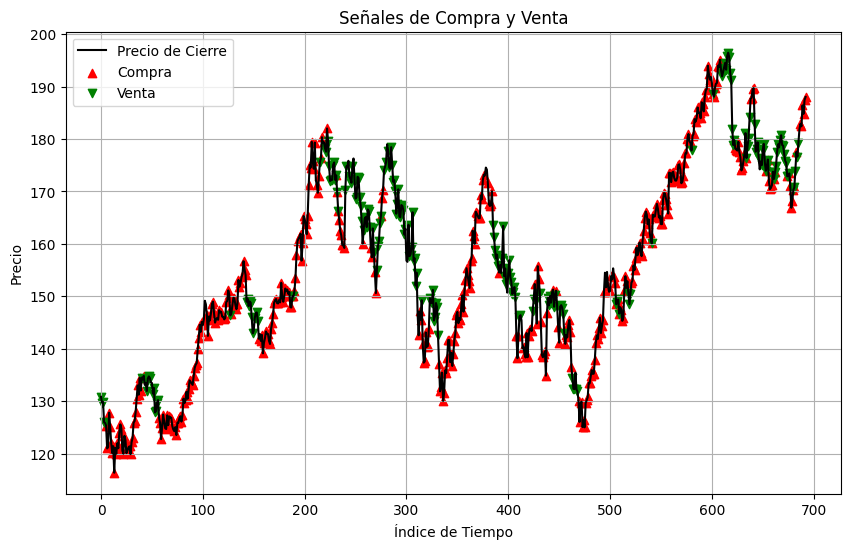

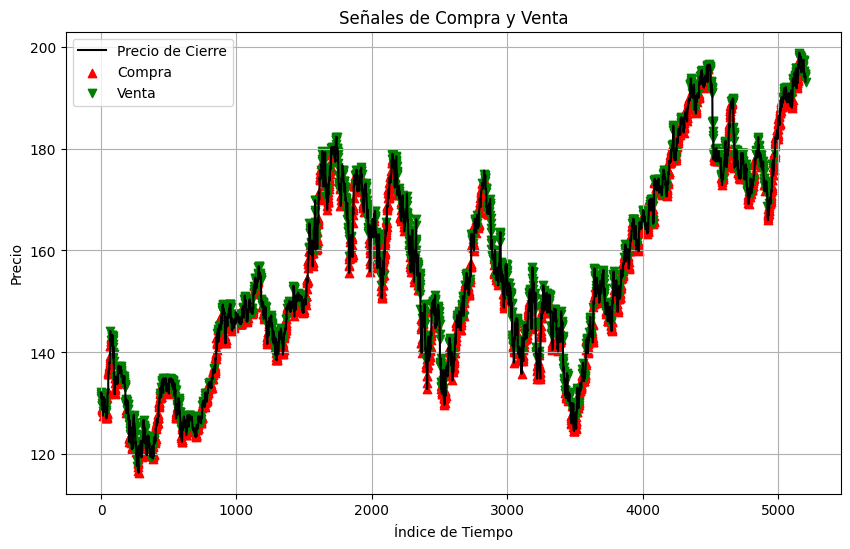

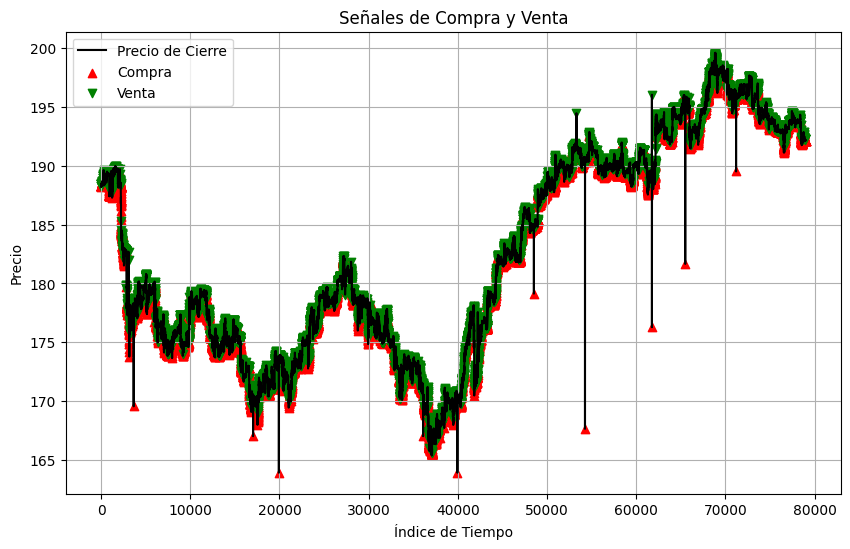

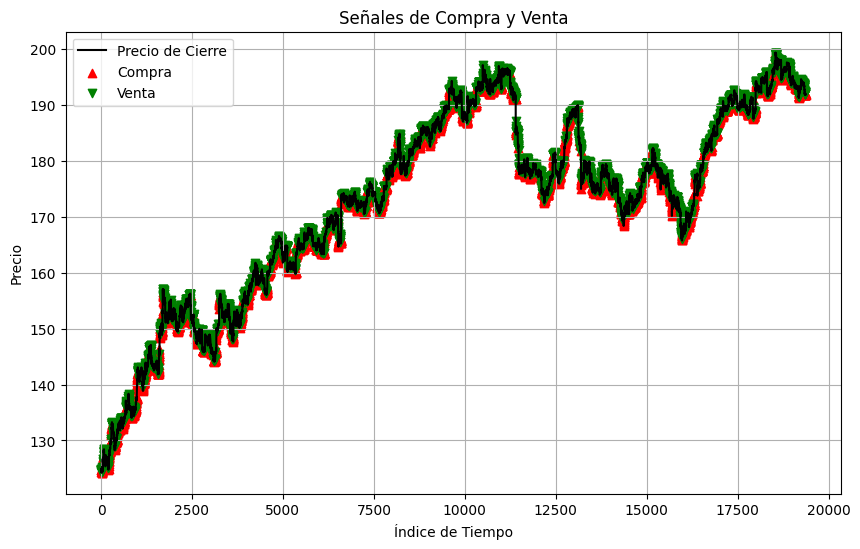

In [10]:
plot_buy_sell_signals(global_buy_signals_1d_long, global_sell_signals_1d_short, dataresult_short_1d_test)
plot_buy_sell_signals(global_buy_signals_1h_long, global_sell_signals_1h_short, dataresult_short_1h_test)
plot_buy_sell_signals(global_buy_signals_1m_long, global_sell_signals_1m_short, dataresult_short_1m_test)
plot_buy_sell_signals(global_buy_signals_5m_long, global_sell_signals_5m_short, dataresult_short_5m_test)

## Optimizacion y backtesting

Una vez se han determinado los mejores parámetros para cada modelo mediante el proceso de finetuning, el proyecto de análisis de aprendizaje automático procede a realizar un proceso de combinaciones con backtesting. Este enfoque busca identificar el mejor modelo y los mejores parámetros a través de la evaluación del rendimiento financiero, específicamente a través del análisis del profit.

El backtesting implica la simulación de estrategias de trading utilizando datos históricos para evaluar el rendimiento de cada modelo y sus parámetros optimizados. Durante este proceso, se aplican las estrategias definidas previamente con los conjuntos de datos históricos para determinar su efectividad en términos de rentabilidad financiera.

El objetivo principal del backtesting es identificar la estrategia de trading que genere el mayor profit o beneficio. Este profit se calcula a partir de las ganancias y pérdidas generadas por las operaciones realizadas según las señales de compra y venta generadas por cada modelo y sus respectivos parámetros.

Al finalizar el proceso de optimización y backtesting, el código proporciona como resultado el mejor modelo, junto con los parámetros óptimos identificados durante el backtesting. Estos resultados representan la estrategia de trading más efectiva y rentable, basada en el análisis histórico de datos y la evaluación de su desempeño financiero.

Se presenta la funcion de backtesting que devuelve los parametros, y la grafica de los primeros 35 datos, ya con la funcion del backtesting y los parametros optimizados obtenidos por el proceso.

In [11]:
portfolio_values_1d, cash_values_1d, operations_history_1d = backtest(data_1d, global_buy_signals_1d_long, global_sell_signals_1d_short, 0.8260391440506059, 1.0994972027471122, 43)
portfolio_values_1h, cash_values_1h, operations_history_1h = backtest(data_1h, global_buy_signals_1h_long, global_sell_signals_1h_short, 0.8045410770677325, 1.0999994091707832, 50)
portfolio_values_1m, cash_values_1m, operations_history_1m = backtest(data_1m, global_buy_signals_1m_long, global_sell_signals_1m_short, 0.8246899075687136, 1.0966755803337889, 47)
portfolio_values_5m, cash_values_5m, operations_history_5m = backtest(data_5m, global_buy_signals_5m_long, global_sell_signals_5m_short, 0.8412379579141974, 1.0997899401664173, 29)

Los mejores parametros se muestran anteriormente en la funcion de backtest, mientras que los mejores modelos fueron: 

    1d: XG
    1h: Logistic, XG
    1m: XG
    5m: XF

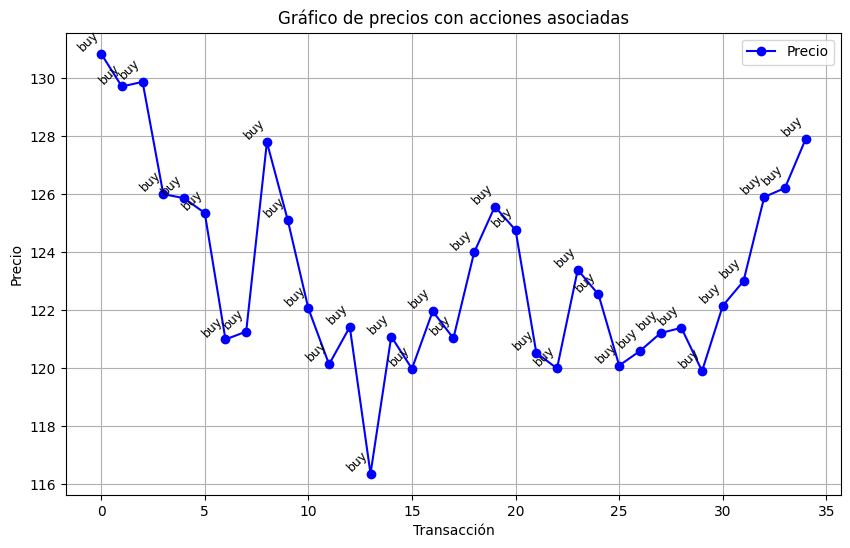

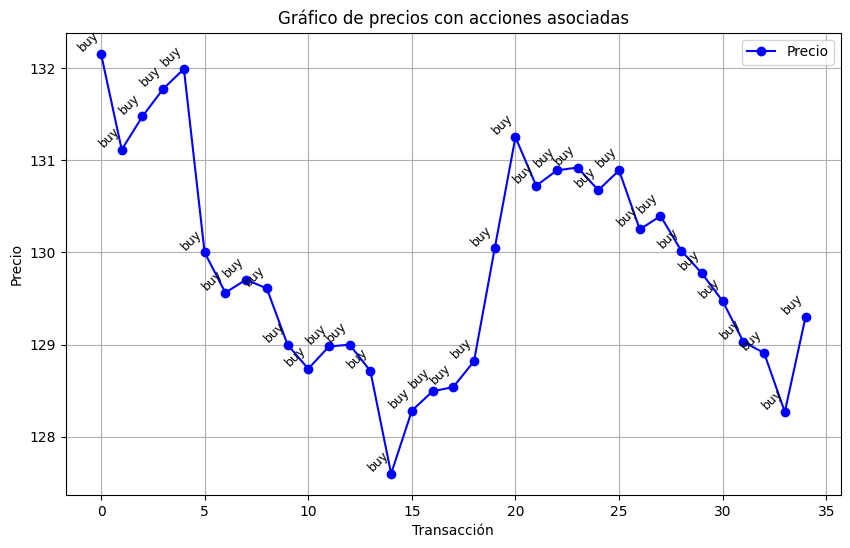

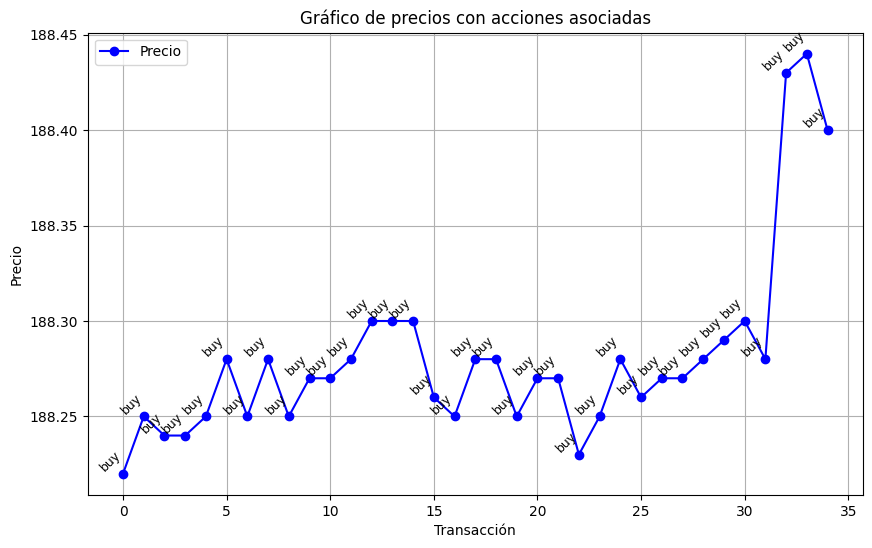

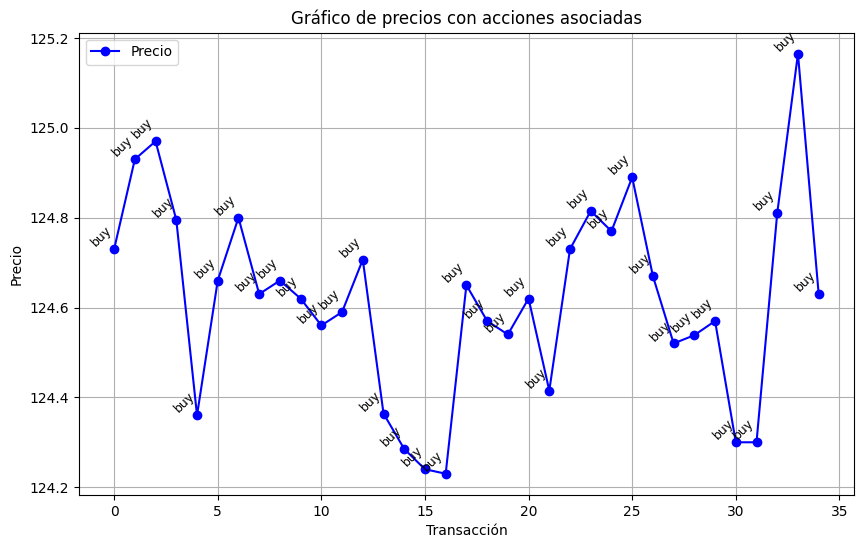

In [12]:
plot_operations_history(operations_history_1d)
plot_operations_history(operations_history_1h)
plot_operations_history(operations_history_1m)
plot_operations_history(operations_history_5m)

## Decisiones con los resultados obtenidos

Decidimos usar el dataset de 1 dia, en lugar de los datasets de 1 minuto, 5 minutos y 1 hora, esto se basa en que el accuracy obtenido en los 4 data sets, realmente no es muy diferente como para ser algo significativo, aparte de la eficiencia computacional y la capacidad predictiva: a pesar de que los datasets de alta frecuencia ofrecen una gran cantidad de información detallada sobre la actividad del mercado, su utilización conlleva una complejidad computacional significativa y puede verse afectada por el ruido y la volatilidad del mercado. El dataset de 1 día proporciona una visión más general y consolidada del comportamiento del mercado a lo largo del tiempo, lo que puede facilitar la identificación de tendencias y patrones de largo plazo.

El codigo nos arojo que el mejor modelo predictivo fue XGBoost con los parámetros de: 

n_estimators: 300

max_depth: 7

learning_rate: 0.01845611375279615

subsample: 0.7

colsample_bytree: 0.9

Estos valores de parámetros se seleccionaron mediante el proceso de optimización y finetuning. XGBoost se destaca por su capacidad para manejar conjuntos de datos grandes, su eficiencia computacional y su capacidad para capturar relaciones no lineales y complejas en los datos, lo que lo hace preferible en muchas aplicaciones de aprendizaje automático.

Los parámetros definidos para la estrategia de trading son fundamentales para determinar su efectividad y gestión del riesgo, los resultados obtenidos por el metodo de optuna fueron:

stop_loss: 0.899950212993615

take_profit: 1.0987292727726978

n_shares: 47

Estos valores determinan el nivel de riesgo y la rentabilidad esperada de la estrategia de trading. Un stop_loss adecuadamente ajustado puede limitar las pérdidas en caso de movimientos desfavorables del mercado, mientras que un take_profit bien definido puede asegurar las ganancias antes de que se reviertan las tendencias del mercado. La cantidad de shares define el tamaño de cada operación y su impacto en el capital inicial.

Con todo esto, pudimos obtener rendimientos que vamos a presentar un poco mas adelante, sin embargo aqui se muestran las graficas del dinero que teniamos atraves del tiempo, y la grafica del valor del portafolio atraves del tiempo tambien. Como podedmos observar ambas tienen buenos rendimientos y no bajan tanto de valor como podria asumirse con el dinero que tienes al iniciar y como va fluctuando con el tiempo.

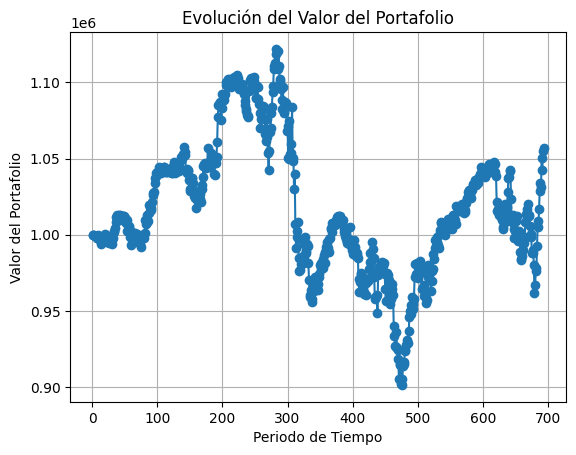

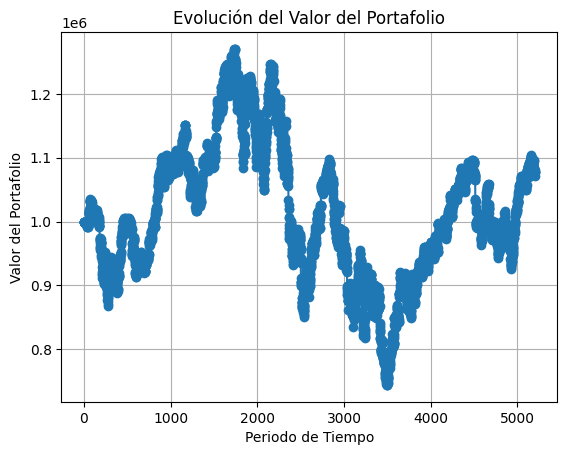

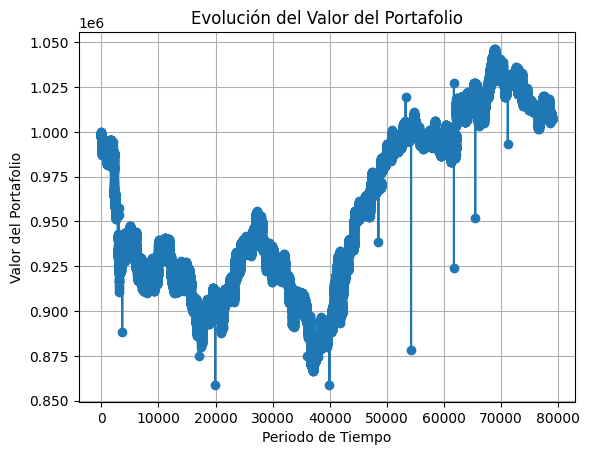

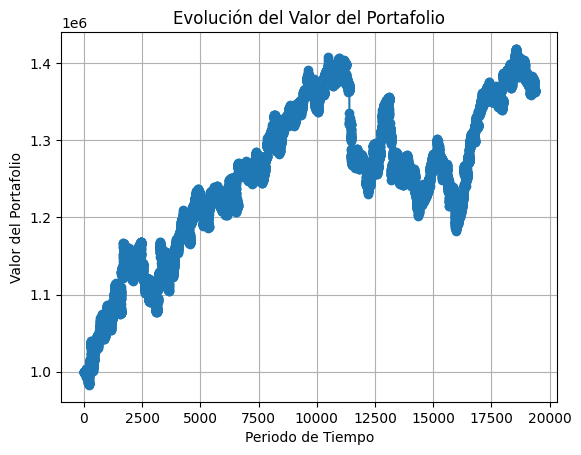

In [13]:
port_value_plot(portfolio_values_1d)
port_value_plot(portfolio_values_1h)
port_value_plot(portfolio_values_1m)
port_value_plot(portfolio_values_5m)

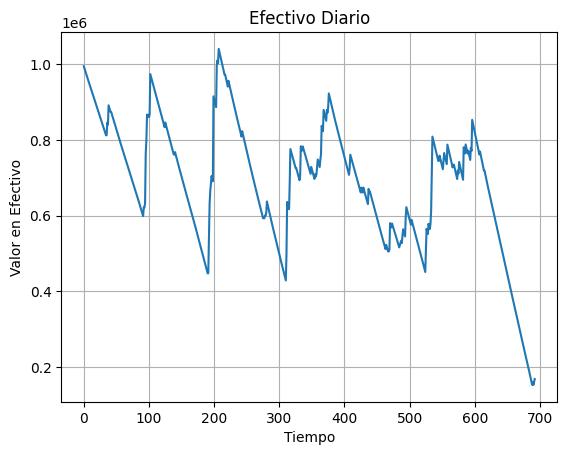

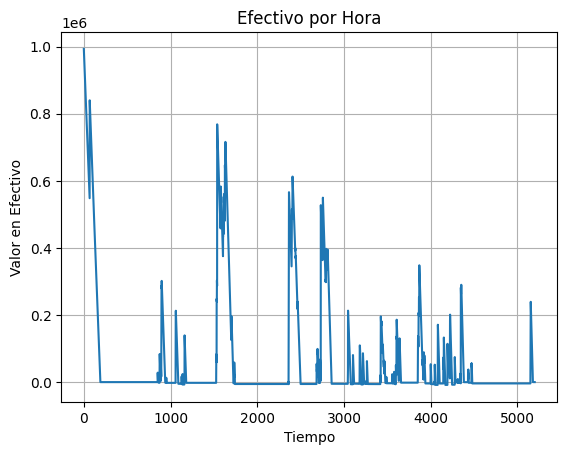

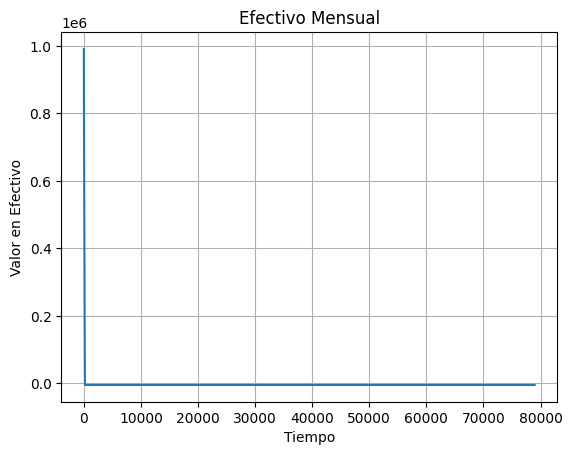

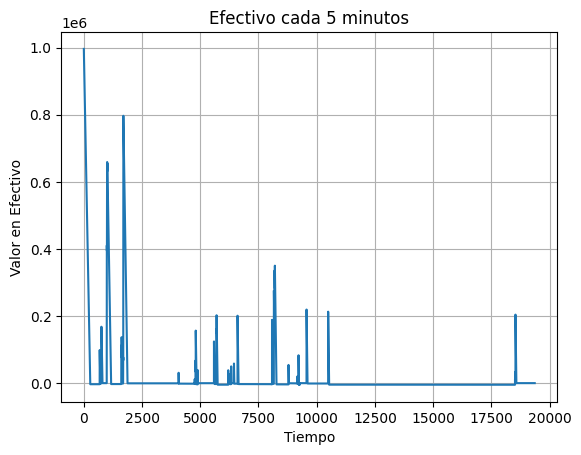

In [14]:
plot_cash(cash_values_1d, 'Efectivo Diario')
plot_cash(cash_values_1h, 'Efectivo por Hora')
plot_cash(cash_values_1m, 'Efectivo Mensual')
plot_cash(cash_values_5m, 'Efectivo cada 5 minutos')

## Resultados en ganancias

El resultado obtenido de nuestro modelo de trading XGBoost, que generó un profit de 1050416.75 con un monto inicial de 1,000,000, revela la efectividad y el potencial de las estrategias basadas en aprendizaje automático en el contexto del mercado financiero. Esta ganancia significativa representa un rendimiento positivo que supera con creces la estrategia pasiva de simplemente mantener el dinero sin arriesgarse.

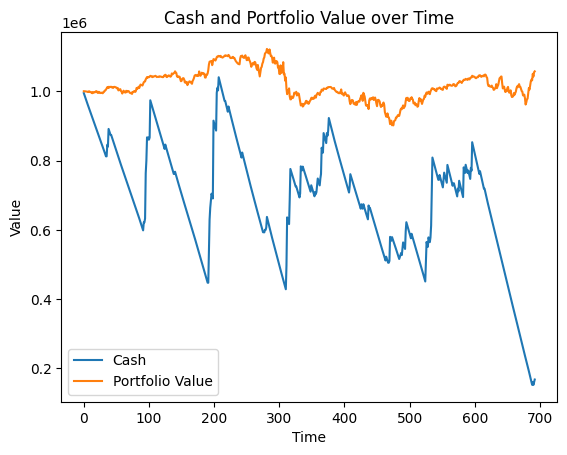

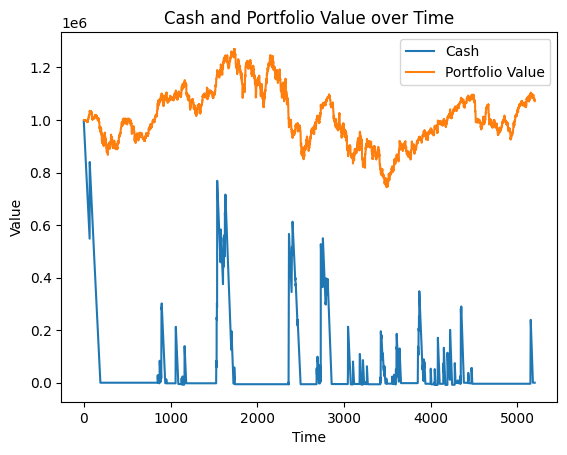

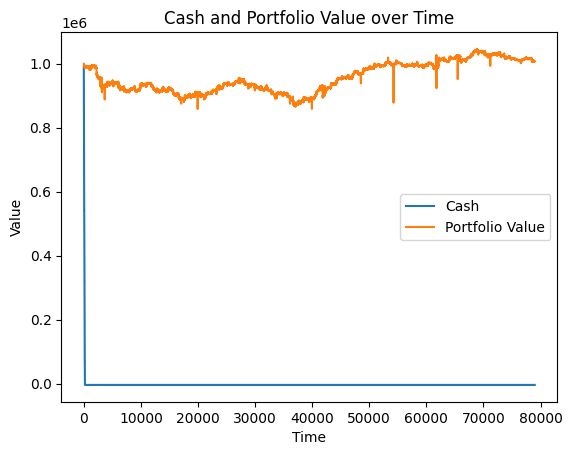

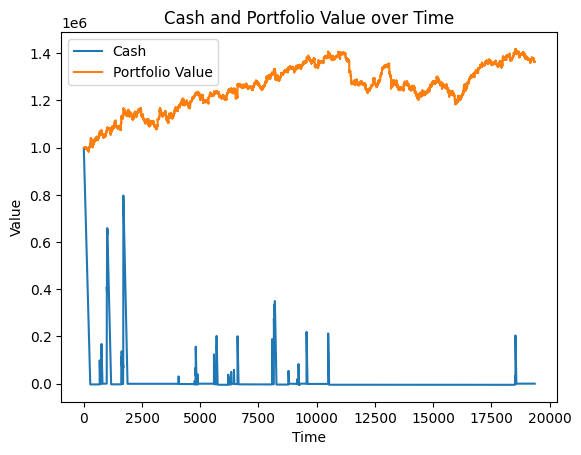

In [15]:
cash_portvalue_plot(cash_values_1d, portfolio_values_1d)
cash_portvalue_plot(cash_values_1h, portfolio_values_1h)
cash_portvalue_plot(cash_values_1m, portfolio_values_1m)
cash_portvalue_plot(cash_values_5m, portfolio_values_5m)

Al comparar el dinero y el valor de portafolio atraves del tiempo, vemos que si tenemos ganancias suficientes para considerar la estrategia como un buen rendimiento.

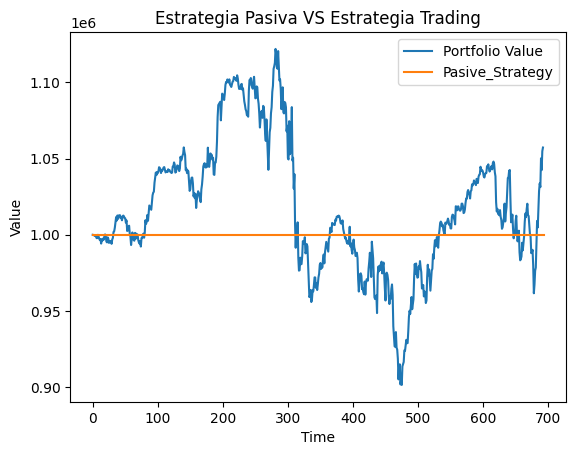

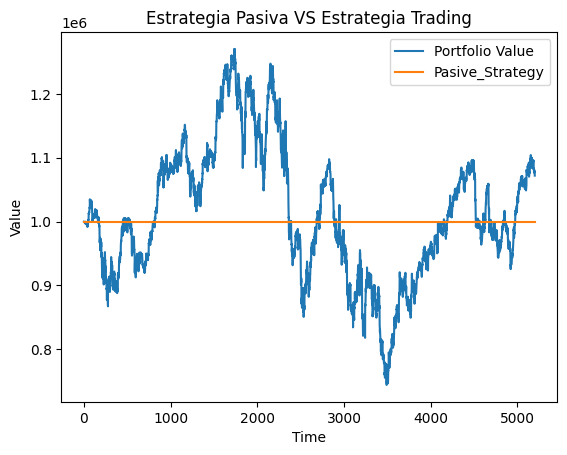

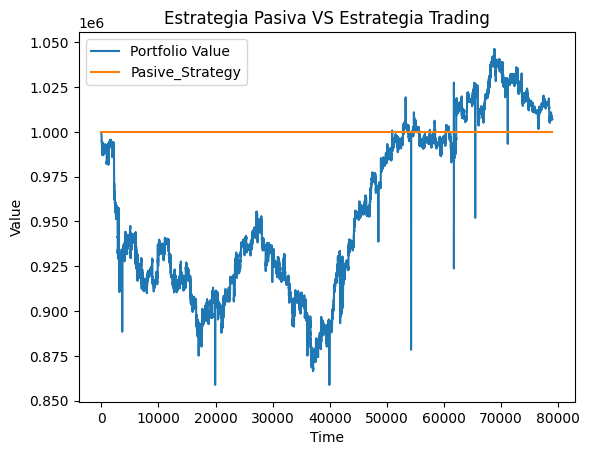

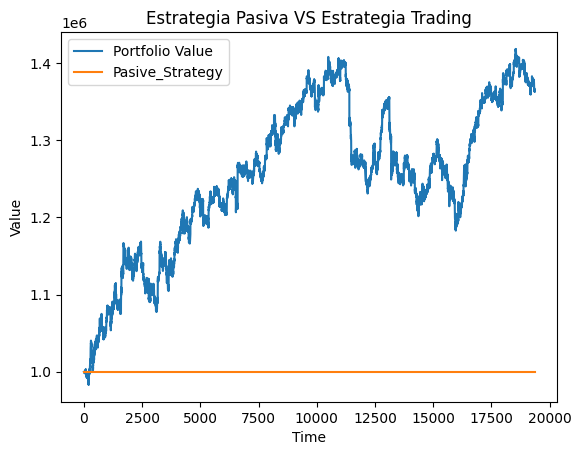

In [16]:
pasive_portvalue_plot(portfolio_values_1d)
pasive_portvalue_plot(portfolio_values_1h)
pasive_portvalue_plot(portfolio_values_1m)
pasive_portvalue_plot(portfolio_values_5m)

## Conclusiones

Eficacia del modelo de trading: La capacidad del modelo XGBoost para generar un profit sustancial demuestra su capacidad para identificar patrones y señales comerciales rentables en los datos históricos del mercado. Este resultado respalda la utilidad y la aplicabilidad de los modelos de aprendizaje automático en la toma de decisiones financieras.

Valor del análisis predictivo: El análisis predictivo facilitado por el aprendizaje automático permite a los inversionistas tomar decisiones informadas y estratégicas, lo que resulta en mayores ganancias y un mejor desempeño en comparación con las estrategias pasivas.

Ganancias potenciales frente a estrategias conservadoras: La diferencia entre el profit generado por el modelo de trading y las ganancias potenciales de una estrategia pasiva resalta la importancia del riesgo y la recompensa en el mercado financiero. Aunque las estrategias conservadoras pueden ofrecer cierta seguridad, también limitan el potencial de ganancias.

Importancia de la optimización y el backtesting: El proceso de optimización de parámetros y el backtesting permiten identificar y validar estrategias comerciales efectivas antes de su implementación en condiciones reales. Estas etapas son fundamentales para mitigar riesgos y maximizar rendimientos en el mercado financiero.